# 1号门年后数据分析 关门合并计算

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
#import pymysql
#pymysql.install_as_MySQLdb()
import MySQLdb as sql
import sklearn.mixture as mix
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns#添加Seaborn模块
%matplotlib inline
from pyecharts import Line

#不输出警告
import warnings
warnings.filterwarnings("ignore")
import time
import datetime
import pickle
from sklearn.externals import joblib
filesave='D:\sl_online'

## 高斯模型

In [3]:
#计算CV值
def calculate_cv(MG1,MG2):

    
    NumMixture1 = MG1.n_components
    NumMixture2 = MG2.n_components
    d = 0.0
    for k in range(0,NumMixture1):
        for j in range(0,NumMixture2):
            Sigma1 = MG1.covariances_[k]
            Mu1 = MG1.means_[k]
            Sigma2 = MG2.covariances_[j]
            Mu2 = MG2.means_[j]
            weight = MG1.weights_[k] * MG2.weights_[j]
            dist = L2Dist(Sigma1,Mu1,Sigma2,Mu2)
            d = d + weight*dist
    ''' the L2 norm of each GMM model'''
    n1 = 0.0
    n2 = 0.0
    for k in range(0,NumMixture1):
        for j in range(0,NumMixture1):
            Sigma1 = MG1.covariances_[k]
            Mu1 = MG1.means_[k]
            Sigma2 = MG1.covariances_[j]
            Mu2 = MG1.means_[j]
            weight = MG1.weights_[k]*MG1.weights_[j]
            n1 = n1 + weight * L2Dist(Sigma1,Mu1,Sigma2,Mu2)
    for k in range(0,NumMixture2):
        for j in range(0,NumMixture2):
            Sigma1 = MG2.covariances_[k]
            Mu1 = MG2.means_[k]
            Sigma2 = MG2.covariances_[j]
            Mu2 = MG2.means_[j]
            weight = MG2.weights_[k]*MG2.weights_[j]
            n2 = n2 + weight * L2Dist(Sigma1,Mu1,Sigma2,Mu2)
    cv = d/np.sqrt(n1)/np.sqrt(n2)
    return cv

In [4]:
#计算两个高斯分布之间的距离
def L2Dist(sigma1,mean1,sigma2,mean2):
    '''
    calculate the L2 distance between two multivariate Gaussian distributisons
    
    '''    
    n = mean1.size
    
    '''L2 norm of sigma1, mean1'''
    
    invsigma1 = np.linalg.inv(sigma1)
    invsigma2 = np.linalg.inv(sigma2)
    u = invsigma1*mean1 + invsigma2*mean2
    invsigma = np.linalg.inv(sigma1+sigma2)
    f1norm = 1/math.sqrt( math.sqrt( (2*math.pi)**n*np.linalg.det(sigma1)*2**n ) )
    '''L2 norm of sigma2, mean2'''
    f2norm = 1/math.sqrt( math.sqrt( (2*math.pi)**n*np.linalg.det(sigma2)*2**n ) )
    '''inner product of pdf f1 and f2'''
    
    InnerProd = 1/(math.sqrt(2*math.pi)**n) * math.sqrt(np.linalg.det(invsigma)) * \
                np.exp(-1/2*(-u.T*sigma1*invsigma*sigma2*u + mean1.T*invsigma1*mean1 + mean2.T*invsigma2*mean2))
    '''L2 distance between f1 and f2'''
    d = InnerProd/f1norm/f2norm
    
    return d

In [5]:
#训练高斯模型
def gmm_clustering(k,X,cov_type=None):
    '''
    基于高斯混合模型GMM进行无监督学习，聚类
    其中GMM采用传统的EM算法进行参数估计
    
    输入参数含义:
    k    ————   聚类的数目，必填项
    X    ————   样本的输入，比填项
    cov_type  ————  协方差类型，可选项
            四种选择：'spherical', 'tied', 'diag', 'full'
            如果不填写，则默认为'full'
        
    '''
    if cov_type is None:
        cov_type = 'full'   
    
    gmm = mix.GaussianMixture(n_components=k,covariance_type=cov_type)
    gmm.fit(X)
    
    return gmm

### 导入数据

In [6]:
# #连接本地数据库
# config={'user': 'root',
#         'passwd': 'ABCabc123',
#         'host': '127.0.0.1',
#         'db': 'maoqing'}
#连接外部数据库
config = {'user': 'root',
             'passwd': 'ABCabc123',
             'host': '10.84.1.20',
             'db': 'maoqing'}
database='door_data_can0902'
sql_statement="select * from "+database+" where HAPPENTIME > '2019-03-19' and GATE = 1 and DOOR_STATE = 0010011100100101 or 0010101100101010 or 0010101100100011"#  read_flag is nulland  

#while(1):
#链接数据库读取新数据
conn = sql.connect(**config)
cur = conn.cursor(cursorclass=sql.cursors.DictCursor)#返回字段名
#根据read_flag为null筛选出新录入的数据
#cur.execute("select * from "+database+" where read_flag is null")#door_data_can 为原始数据表名
#data=cur.fetchall()#执行读取操作
#rawdata_can = pd.DataFrame(list(data))#将读取结果转为dataframe格式
rawdata_can=pd.read_sql(sql_statement,conn)
rawdata_can.head()
#将HAPPENTIME列属性改为时间，并设置为index        
rawdata_can['HAPPENTIME']=pd.to_datetime(rawdata_can['HAPPENTIME'])
rawdata_can=rawdata_can.set_index('HAPPENTIME')
# rawdata_can=rawdata_can.set_index('id')
rawdata_can.shape
rawdata_can.head()

,id,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,ID_SUM_N,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result
HAPPENTIME,,,,,,,,,,,,,,,,,,,,,
2018-11-20 14:54:11,1,MJYXSJID-10000,2018/11/20 14:54:12,2018/11/20 14:54:12,2018/11/20 14:54:12,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0010001000000010,0,BAK1,Bak2,,1,,,
2018-11-20 14:54:12,2,MJYXSJID-10001,2018/11/20 14:54:12,2018/11/20 14:54:12,2018/11/20 14:54:12,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0000001000101010,77,BAK1,Bak2,,1,,,
2018-11-20 14:54:46,3,MJYXSJID-10002,2018/11/20 14:54:47,2018/11/20 14:54:47,2018/11/20 14:54:47,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,115,0010101000100010,0,BAK1,Bak2,,1,,,
2018-11-20 14:54:56,4,MJYXSJID-10003,2018/11/20 14:54:57,2018/11/20 14:54:57,2018/11/20 14:54:57,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,0,0010001000000010,0,BAK1,Bak2,,1,,,
2018-11-20 14:54:57,5,MJYXSJID-10004,2018/11/20 14:54:57,2018/11/20 14:54:57,2018/11/20 14:54:57,20170830,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,229458,0000001000100110,111,BAK1,Bak2,,1,,,


In [8]:
#筛选开门数据
rawdata_can_open1=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(1))].loc[:'2019-04-01',:]
rawdata_can_open2=rawdata_can[(rawdata_can['DOOR_STATE'].astype(str)=='0010011100100101')&(rawdata_can['GATE'].astype(str)==str(1))&(rawdata_can['DOOR_STATE_Z'].astype(str)=='0010011000100111')].loc['2019-04-01':,:]
rawdata_can_open=rawdata_can_open1.append(rawdata_can_open2)
rawdata_can_open=rawdata_can_open.loc[:,['E_Q', 'E_D', 'SPEED_SUM',  'SPEED_MAX_P',
   'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
   'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM','SPEED_SUM_SQR','SPEED_SUM_CNT']].copy()
rawdata_can_open=rawdata_can_open.dropna()#删除缺失数据
rawdata_can_open=rawdata_can_open.astype('float')#强转数据类型
rawdata_can_open['SPEED_SUM_SQR_REAL'] = rawdata_can_open['SPEED_SUM_SQR']/rawdata_can_open['SPEED_SUM_CNT']
rawdata_can_open=rawdata_can_open.drop(labels=['SPEED_SUM_SQR','SPEED_SUM_CNT'],axis=1)#删除计算后的两列
rawdata_can_open.head()


,E_Q,E_D,SPEED_SUM,SPEED_MAX_P,SPEED_MAX_N,SPEED_MAX_N_POSITION,START_POSITION,END_POSITION,IQ_SUM_P,IQ_SUM_N,ID_SUM_P,ID_SUM_N,EM,SPEED_SUM_SQR_REAL
HAPPENTIME,,,,,,,,,,,,,,
2019-01-25 11:11:34,371,-2,-1386,60,-72,34597,35507,16582,0,11042185,132853,142923,128,365.694572
2019-01-25 11:11:43,231,-1,-3041,96,-1076,22016,35600,16582,0,6170183,72359,68448,148,6643.988180
2019-01-25 11:11:56,229,-1,-2654,84,-1016,22011,35586,16582,0,6077221,67788,63658,148,5524.517815
2019-01-25 11:12:09,230,-1,-2614,84,-996,22010,35586,16582,0,6123646,71851,66599,148,5382.475059
2019-01-25 11:12:21,232,-1,-2574,100,-976,22009,35584,16582,0,6174718,77863,76999,149,5260.479810


In [10]:
#筛选关门数据和关门不到位数据
rawdata_can_close=rawdata_can[((rawdata_can['DOOR_STATE'].astype(str)=='0010101100101010')^(rawdata_can['DOOR_STATE'].astype(str)=='0010101100100011'))&(rawdata_can['GATE'].astype(str)==str(1))] #
rawdata_can_close.groupby('DOOR_STATE').count()

,id,MJYXSJID,UPLOADTIME,RECEIVETIME,SAVETIME,VERSION_UP,ELE_ID,DEVICE_ID,COMM_PORT,SEQ_ID,...,ID_SUM_N,DOOR_STATE_Z,EM,BACKUP1,BACKUP2,CV,read_flag,alarm_level,actual_result,predicte_result
DOOR_STATE,,,,,,,,,,,,,,,,,,,,,
0010101100100011,830,830,830,830,830,830,830,830,830,830,...,830,830,830,830,830,830,830,830,830,830
0010101100101010,291267,291267,291267,291267,291267,291267,291267,291267,291267,291267,...,291267,291267,291267,291267,291267,291267,291267,291267,291267,291267


In [11]:
rawdata_can_close=rawdata_can_close.loc[:,['E_Q', 'E_D', 'SPEED_SUM',  'SPEED_MAX_P',
   'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
   'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM','SPEED_SUM_SQR','SPEED_SUM_CNT']].copy()
# rawdata_can_close=rawdata_can_close.dropna()#删除缺失数据
rawdata_can_close=rawdata_can_close.astype('float')#强转数据类型
rawdata_can_close['SPEED_SUM_SQR_REAL'] = rawdata_can_close['SPEED_SUM_SQR']/rawdata_can_close['SPEED_SUM_CNT']
rawdata_can_close=rawdata_can_close.drop(labels=['SPEED_SUM_SQR','SPEED_SUM_CNT'],axis=1)#删除计算后的两列
rawdata_can_close=rawdata_can_close.dropna()#删除缺失数据
rawdata_can_close.head()

,E_Q,E_D,SPEED_SUM,SPEED_MAX_P,SPEED_MAX_N,SPEED_MAX_N_POSITION,START_POSITION,END_POSITION,IQ_SUM_P,IQ_SUM_N,ID_SUM_P,ID_SUM_N,EM,SPEED_SUM_SQR_REAL
HAPPENTIME,,,,,,,,,,,,,,
2019-01-25 11:11:38,189.0,-1.0,10517.0,2856.0,-114.0,30114.0,16823.0,35745.0,4656207.0,0.0,54668.0,51056.0,137.0,81057.599388
2019-01-25 11:11:39,12.0,-1.0,1365.0,367.0,-173.0,35787.0,35741.0,35745.0,703582.0,3.0,1964.0,1727.0,2.0,45344.230769
2019-01-25 11:11:51,323.0,-2.0,440.0,60.0,-53.0,26187.0,16815.0,35745.0,9042003.0,0.0,123190.0,106466.0,120.0,255.891892
2019-01-25 11:12:04,323.0,-2.0,1104.0,587.0,-44.0,17288.0,16836.0,35745.0,9128834.0,0.0,123522.0,106288.0,120.0,587.907538
2019-01-25 11:12:17,326.0,-2.0,944.0,447.0,-40.0,17127.0,16834.0,35745.0,9175668.0,0.0,123900.0,106872.0,121.0,435.063317


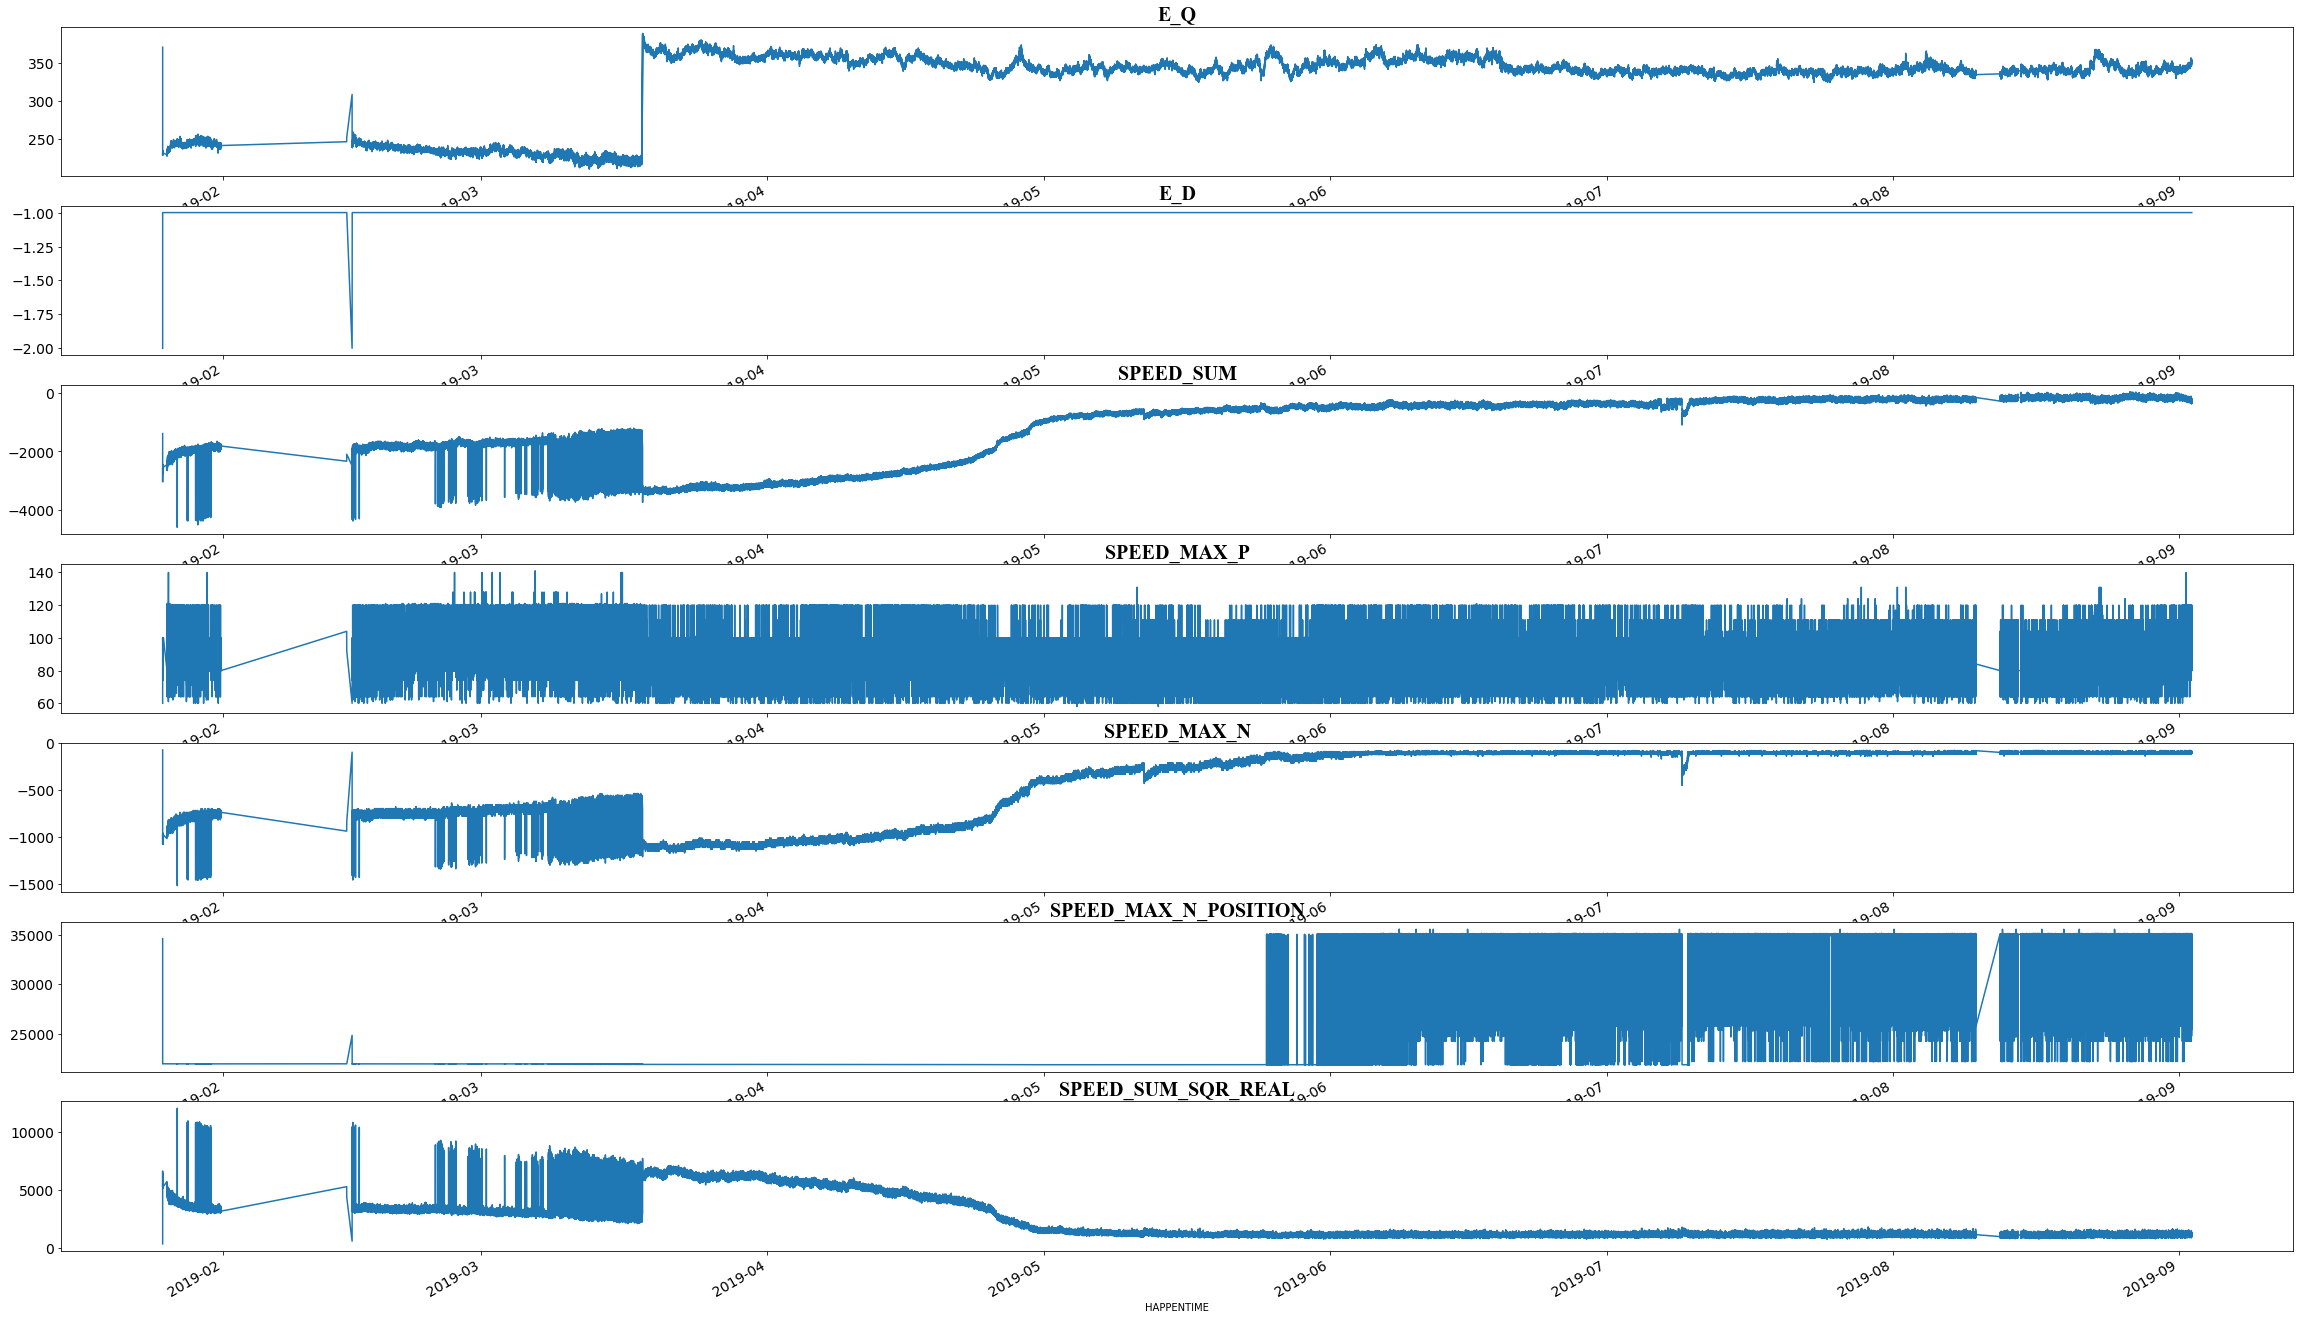

In [12]:
#开门原始数据可视化
rawdata_can_open1=rawdata_can_open.copy()
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
clounmlist=['E_Q', 'E_D', 'SPEED_SUM', 'SPEED_MAX_P',
            'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
            'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM',
            'SPEED_SUM_SQR_REAL']

plt.subplot(711)
rawdata_can_open1['E_Q'].plot()
plt.title('E_Q',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['E_D'].plot()
plt.title('E_D',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['SPEED_SUM'].plot()
plt.title('SPEED_SUM',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['SPEED_MAX_P'].plot()
plt.title('SPEED_MAX_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['SPEED_MAX_N'].plot()
plt.title('SPEED_MAX_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(716)
rawdata_can_open1['SPEED_MAX_N_POSITION'].plot()
plt.title('SPEED_MAX_N_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['SPEED_SUM_SQR_REAL'].plot()
plt.title('SPEED_SUM_SQR_REAL',fontdict=font)
plt.tick_params(labelsize=14)

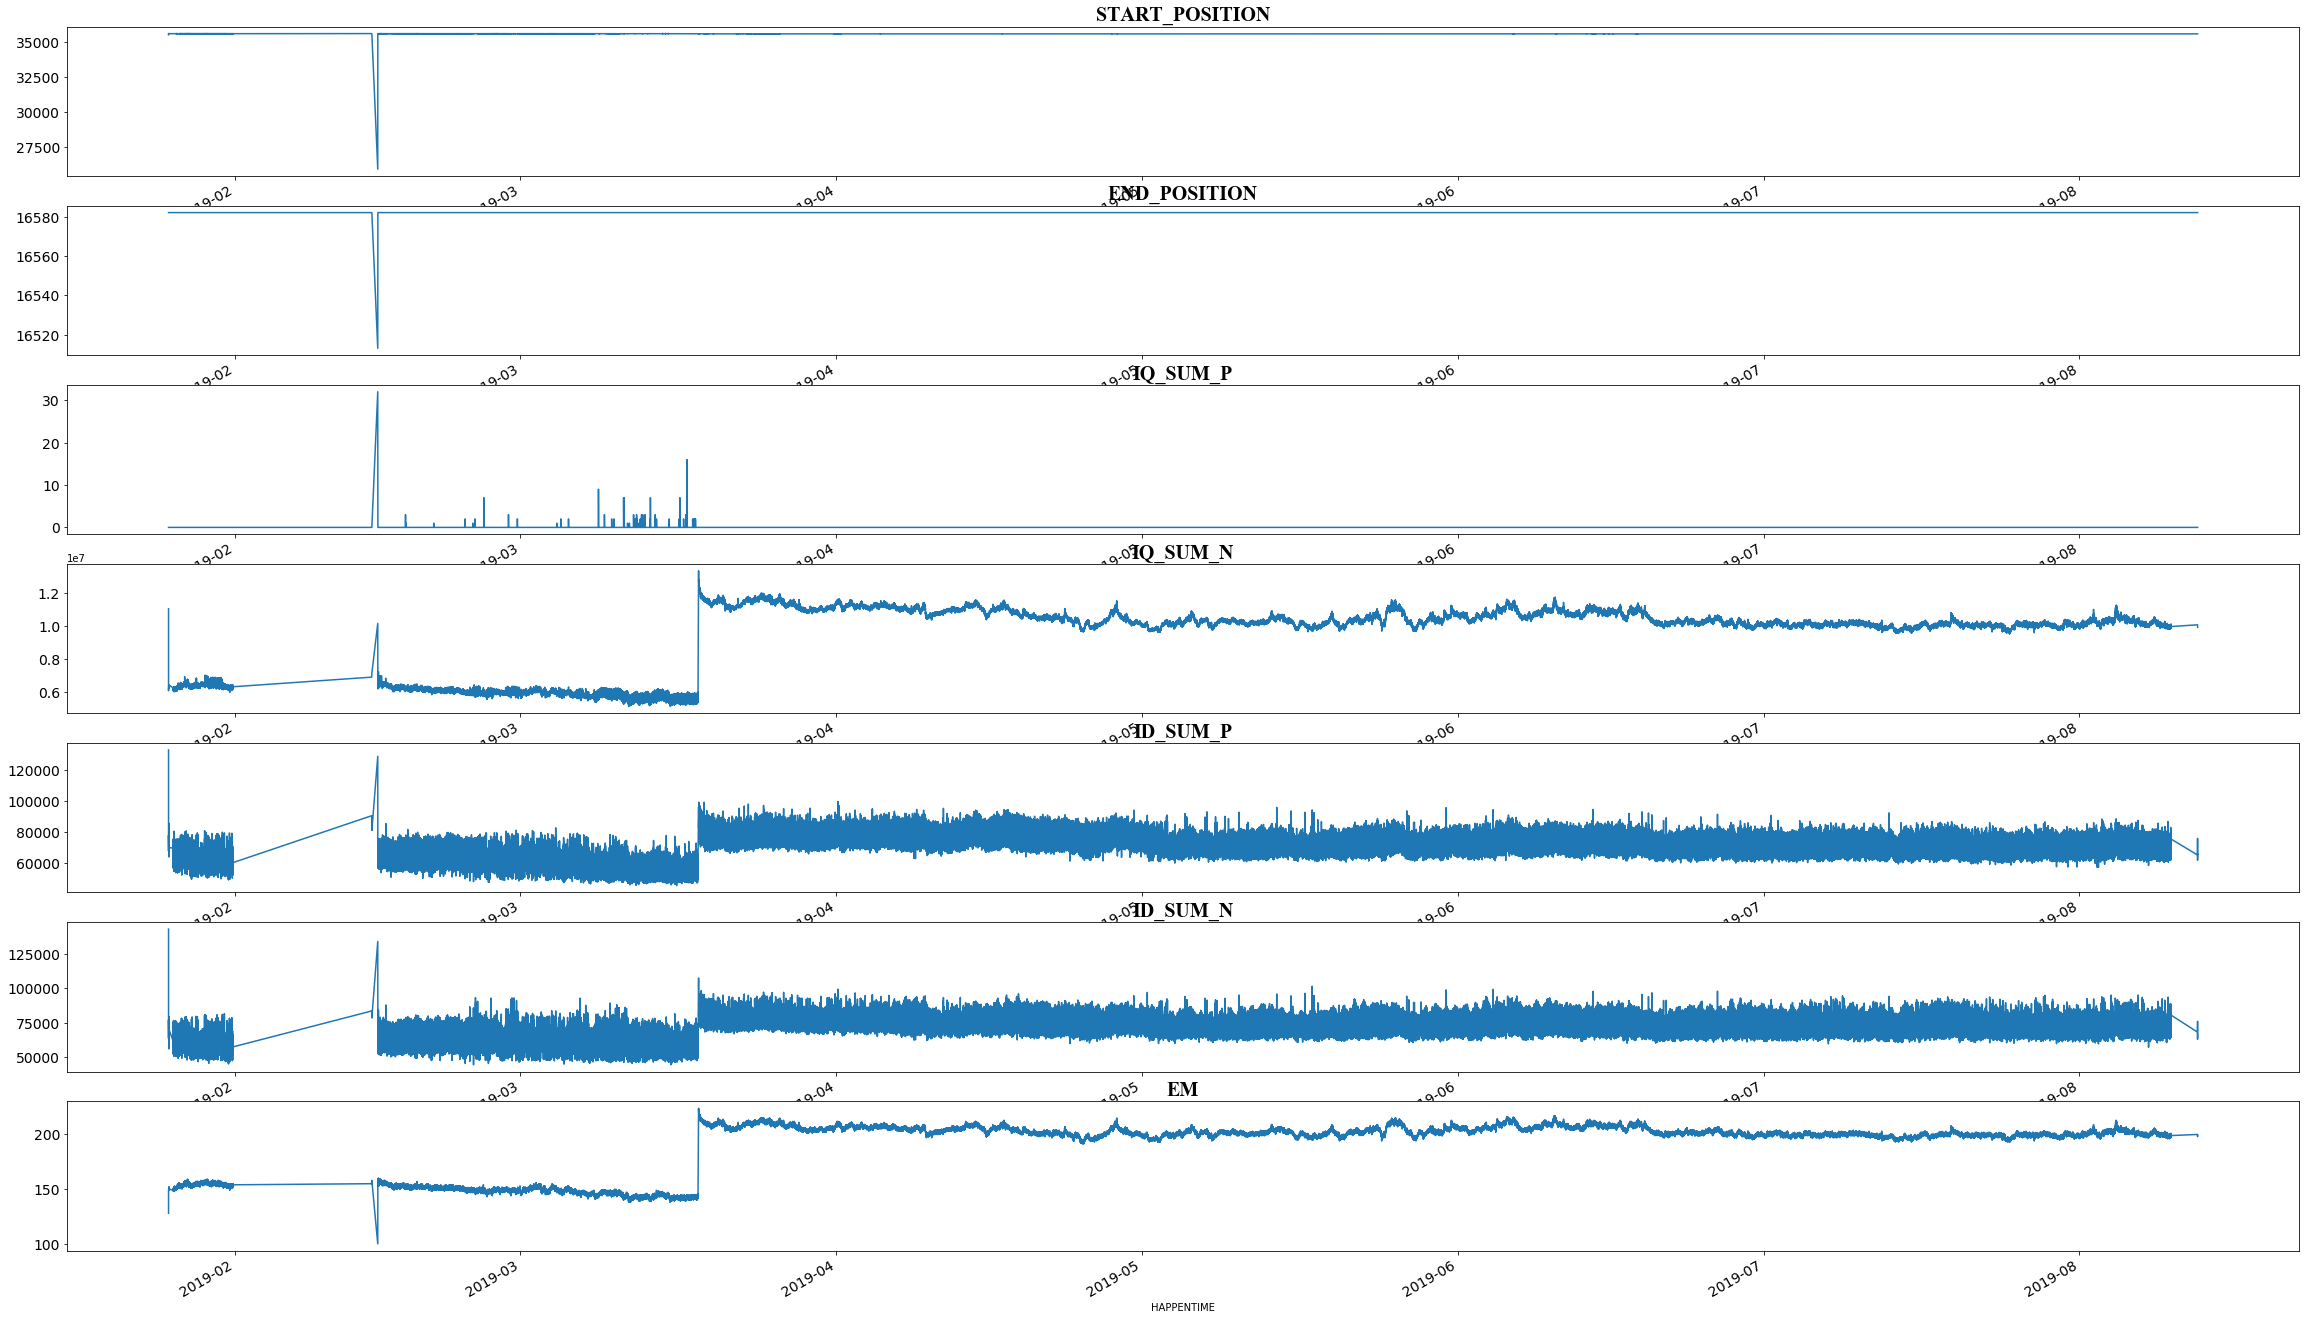

In [10]:
#开门原始数据可视化
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
plt.subplot(711)
rawdata_can_open1['START_POSITION'].plot()
plt.title('START_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['END_POSITION'].plot()
plt.title('END_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['IQ_SUM_P'].plot()
plt.title('IQ_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['IQ_SUM_N'].plot()
plt.title('IQ_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['ID_SUM_P'].plot()
plt.title('ID_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(716)
rawdata_can_open1['ID_SUM_N'].plot()
plt.title('ID_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['EM'].plot()
plt.title('EM',fontdict=font)
plt.tick_params(labelsize=14)


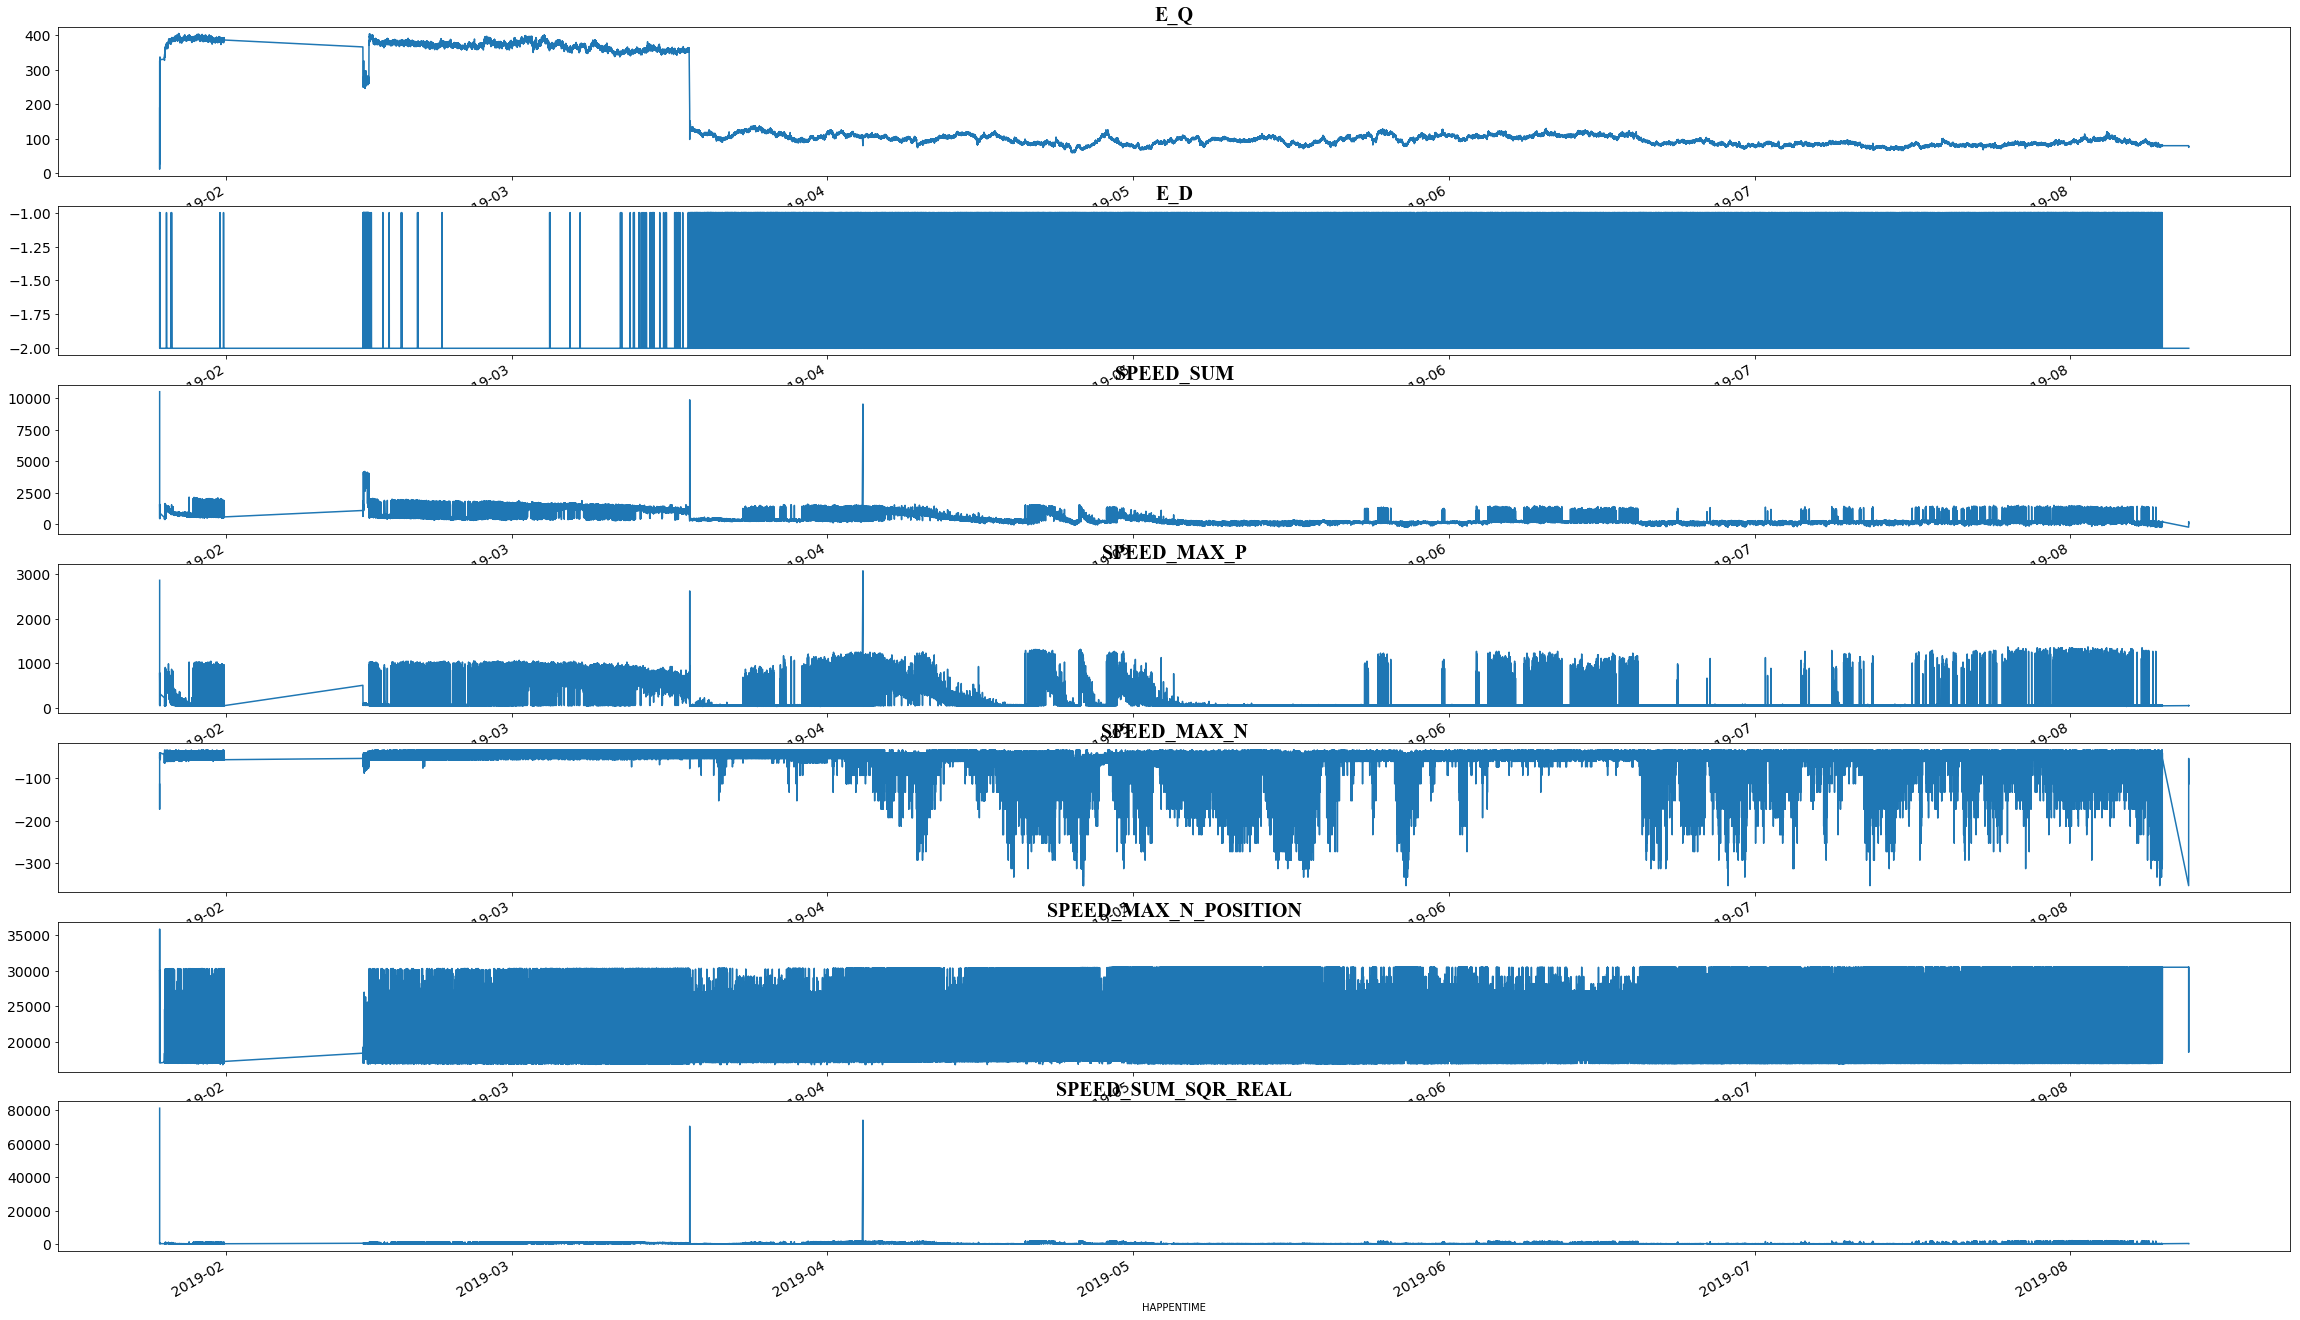

In [11]:
#关门原始数据可视化
rawdata_can_open1=rawdata_can_close.copy()
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
clounmlist=['E_Q', 'E_D', 'SPEED_SUM', 'SPEED_SUM_CNT', 'SPEED_MAX_P',
            'SPEED_MAX_N', 'SPEED_MAX_N_POSITION', 'START_POSITION', 'END_POSITION',
            'IQ_SUM_P', 'IQ_SUM_N', 'ID_SUM_P', 'ID_SUM_N', 'EM',
            'SPEED_SUM_SQR_REAL']

plt.subplot(711)
rawdata_can_open1['E_Q'].plot()
plt.title('E_Q',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['E_D'].plot()
plt.title('E_D',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['SPEED_SUM'].plot()
plt.title('SPEED_SUM',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(714)
rawdata_can_open1['SPEED_MAX_P'].plot()
plt.title('SPEED_MAX_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['SPEED_MAX_N'].plot()
plt.title('SPEED_MAX_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(716)
rawdata_can_open1['SPEED_MAX_N_POSITION'].plot()
plt.title('SPEED_MAX_N_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['SPEED_SUM_SQR_REAL'].plot()
plt.title('SPEED_SUM_SQR_REAL',fontdict=font)
plt.tick_params(labelsize=14)

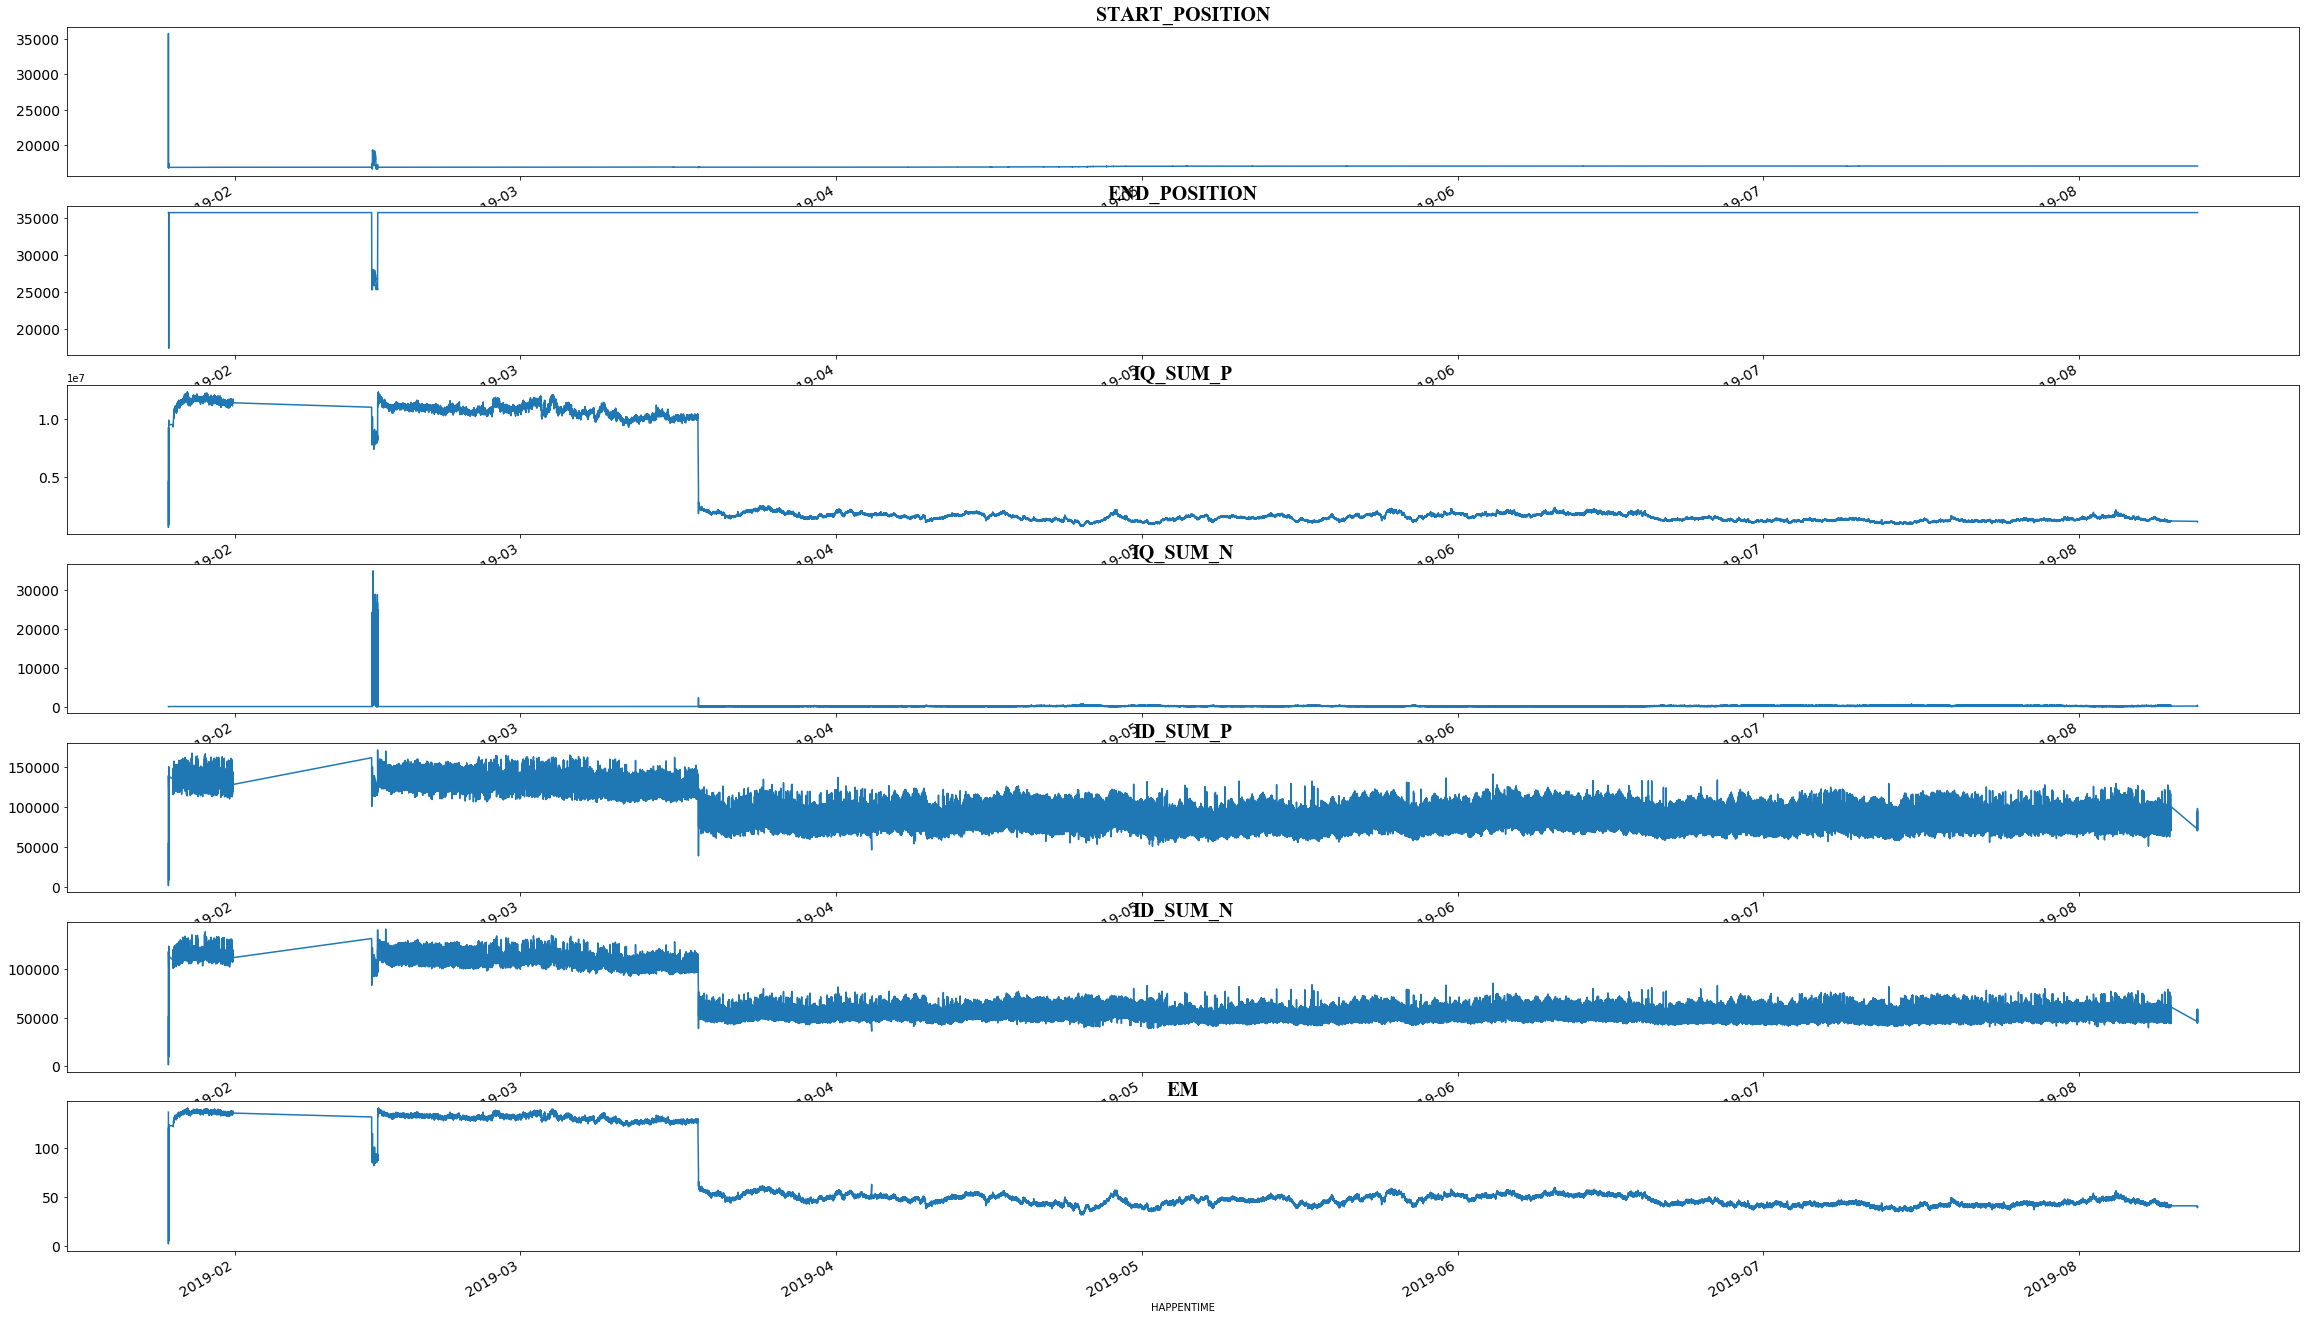

In [12]:
#关门原始数据可视化
font= {'family': 'Times New Roman',
         'weight': 'bold',
         'size':20,
         }
plt.figure(figsize=(40,25))
plt.subplot(711)
rawdata_can_open1['START_POSITION'].plot()
plt.title('START_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(712)
rawdata_can_open1['END_POSITION'].plot()
plt.title('END_POSITION',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(713)
rawdata_can_open1['IQ_SUM_P'].plot()
plt.title('IQ_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(714)
rawdata_can_open1['IQ_SUM_N'].plot()
plt.title('IQ_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(715)
rawdata_can_open1['ID_SUM_P'].plot()
plt.title('ID_SUM_P',fontdict=font)
plt.tick_params(labelsize=14)

plt.subplot(716)
rawdata_can_open1['ID_SUM_N'].plot()
plt.title('ID_SUM_N',fontdict=font)
plt.tick_params(labelsize=14)
plt.subplot(717)
rawdata_can_open1['EM'].plot()
plt.title('EM',fontdict=font)
plt.tick_params(labelsize=14)


In [13]:
#对所有的特征做归一化处理 
from sklearn import preprocessing
#原始数据
data_st1_nors = rawdata_can_open.copy()
data_st2_nors = rawdata_can_close.copy()
#data_st1_nors = rawdata_can_open.iloc[1000:][:].copy()
#data_st2_nors = rawdata_can_close.iloc[1000:][:].copy()



#load标准化模型
standardscaler_st1 = joblib.load(filesave+'\onlycan_opendata_sd_model1.pkl') 

standardscaler_st2 = joblib.load(filesave+'\onlycan_closedata_sd_model1.pkl') 


#使用该模型将未去除离群点的数据归一化
data_st1_sd = standardscaler_st1.transform(data_st1_nors)
data_st1_sd = pd.DataFrame(data_st1_sd)
#data_st1_sd['HAPPENTIME']=data_st1_nors.index
#data_st1_sd=data_st1_sd.set_index('HAPPENTIME')
data_st1_sd.index=data_st1_nors.index
data_st1_sd.columns=data_st1_nors.columns

data_st2_sd = standardscaler_st2.transform(data_st2_nors)
data_st2_sd = pd.DataFrame(data_st2_sd)
#data_st2_sd['HAPPENTIME']=data_st2_nors.index
#data_st2_sd=data_st2_sd.set_index('HAPPENTIME')
data_st2_sd.index=data_st2_nors.index
data_st2_sd.columns=data_st2_nors.columns

print(data_st1_sd.mean(axis=0))#应该都是0
print(data_st1_sd.std(axis=0))#应该都是1



E_Q                       -3.388238
E_D                       -0.000007
SPEED_SUM                 -6.257712
SPEED_MAX_P                0.562334
SPEED_MAX_N               -2.863029
SPEED_MAX_N_POSITION    4522.176730
START_POSITION             6.223310
END_POSITION              -0.000236
IQ_SUM_P                   0.000594
IQ_SUM_N                  -1.897617
ID_SUM_P                   0.097191
ID_SUM_N                  -0.080087
EM                        -2.499279
SPEED_SUM_SQR_REAL        13.607715
dtype: float64
E_Q                       12.962169
E_D                        0.002614
SPEED_SUM                 26.736840
SPEED_MAX_P                1.358615
SPEED_MAX_N               25.566111
SPEED_MAX_N_POSITION    5433.418434
START_POSITION            31.344505
END_POSITION               0.127537
IQ_SUM_P                   0.078155
IQ_SUM_N                  12.596374
ID_SUM_P                   3.323710
ID_SUM_N                   3.064612
EM                        11.555806
SPEED_SUM_SQR

In [14]:
def count_gmm(x):
    if x > 0.5:
        return 1
    else:
        return 0

### 开门数据

In [15]:
#建立高斯混合模型---开门状态
if __name__ == '__main__':
    k = 1
    cv1 = np.zeros(1)
    #data_so = data_st1_sd.copy()
    data_s = data_st1_sd.copy()
    
    normal_obj = joblib.load(filesave+'\onlycan_opendata_normal_obj_model1.pkl') 
    a = len(data_s)
    cv = np.zeros(a)

    
    #使用高斯混合模型进行计算
    def gmm_apply(x,k,normal_obj):
        data_l = pd.DataFrame(x)
        test_obj = gmm_clustering(k,data_l)#test_obj为训练好的gmm模型，需保存
        y = calculate_cv(normal_obj,test_obj)#y为[[cv值]]，只返回cv值
        return y[0][0]
    
    #计算每一行的cv值，存在data_s的cv列中         
    data_s['cv']=data_s.apply(lambda row:gmm_apply(row,k,normal_obj), axis=1)
    
    #计算cv的均值
    #cv1= data_s['cv']#cv1为Series
    #print(type(cv1))
    c = data_s['cv'].mean()
    #计算cv值小于设定阈值的个数
    count =0    
    data_s['health_label']=data_s['cv'].map(count_gmm) 
    count=data_s['health_label'].sum()   
    
    
    print(a)
    print(count)    
    print(c)
   # print(cv1.head())

    data_s_open=data_s.copy()
    


292703
38560
0.22116021150758142


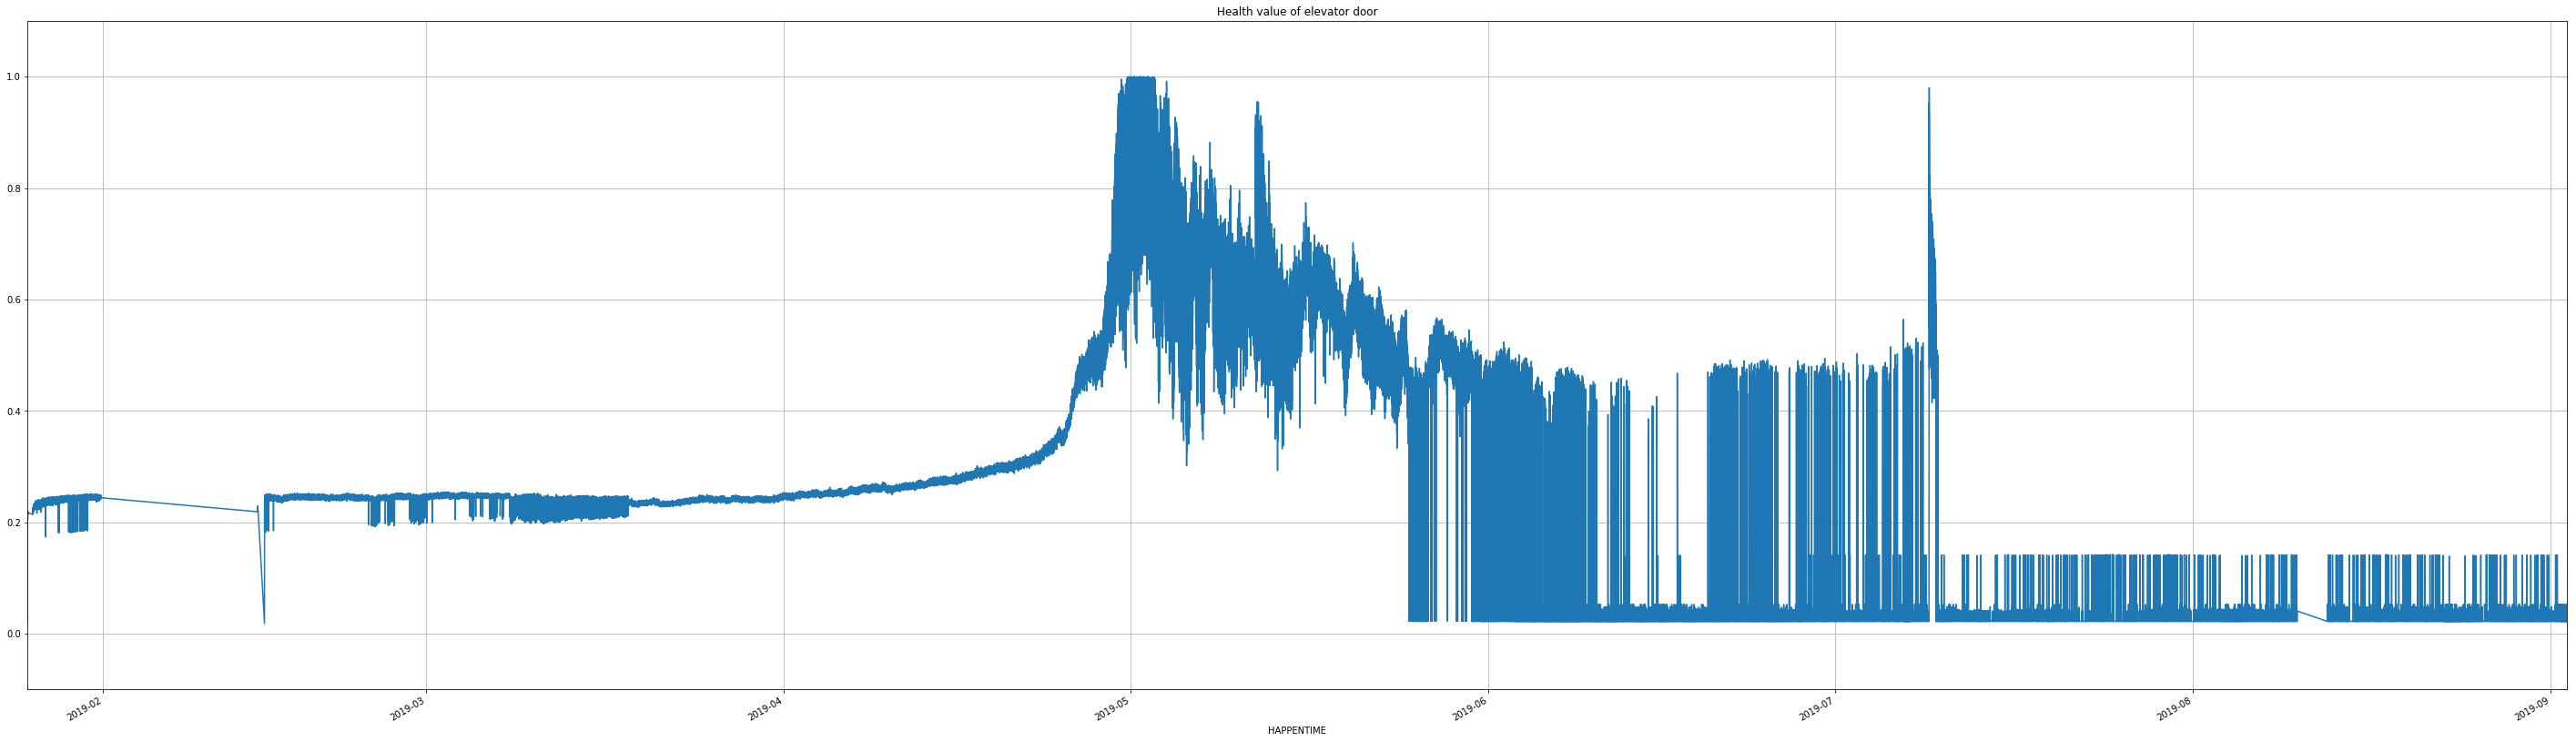

In [16]:
#画图    
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
#plt.xlim(0,14287)
plt.xlim(data_s_open.index[0],data_s_open.index[-1])
#plt.plot(data_s['cv'])
data_s_open['cv'].plot()

plt.grid()
plt.title('Health value of elevator door')
plt.show()


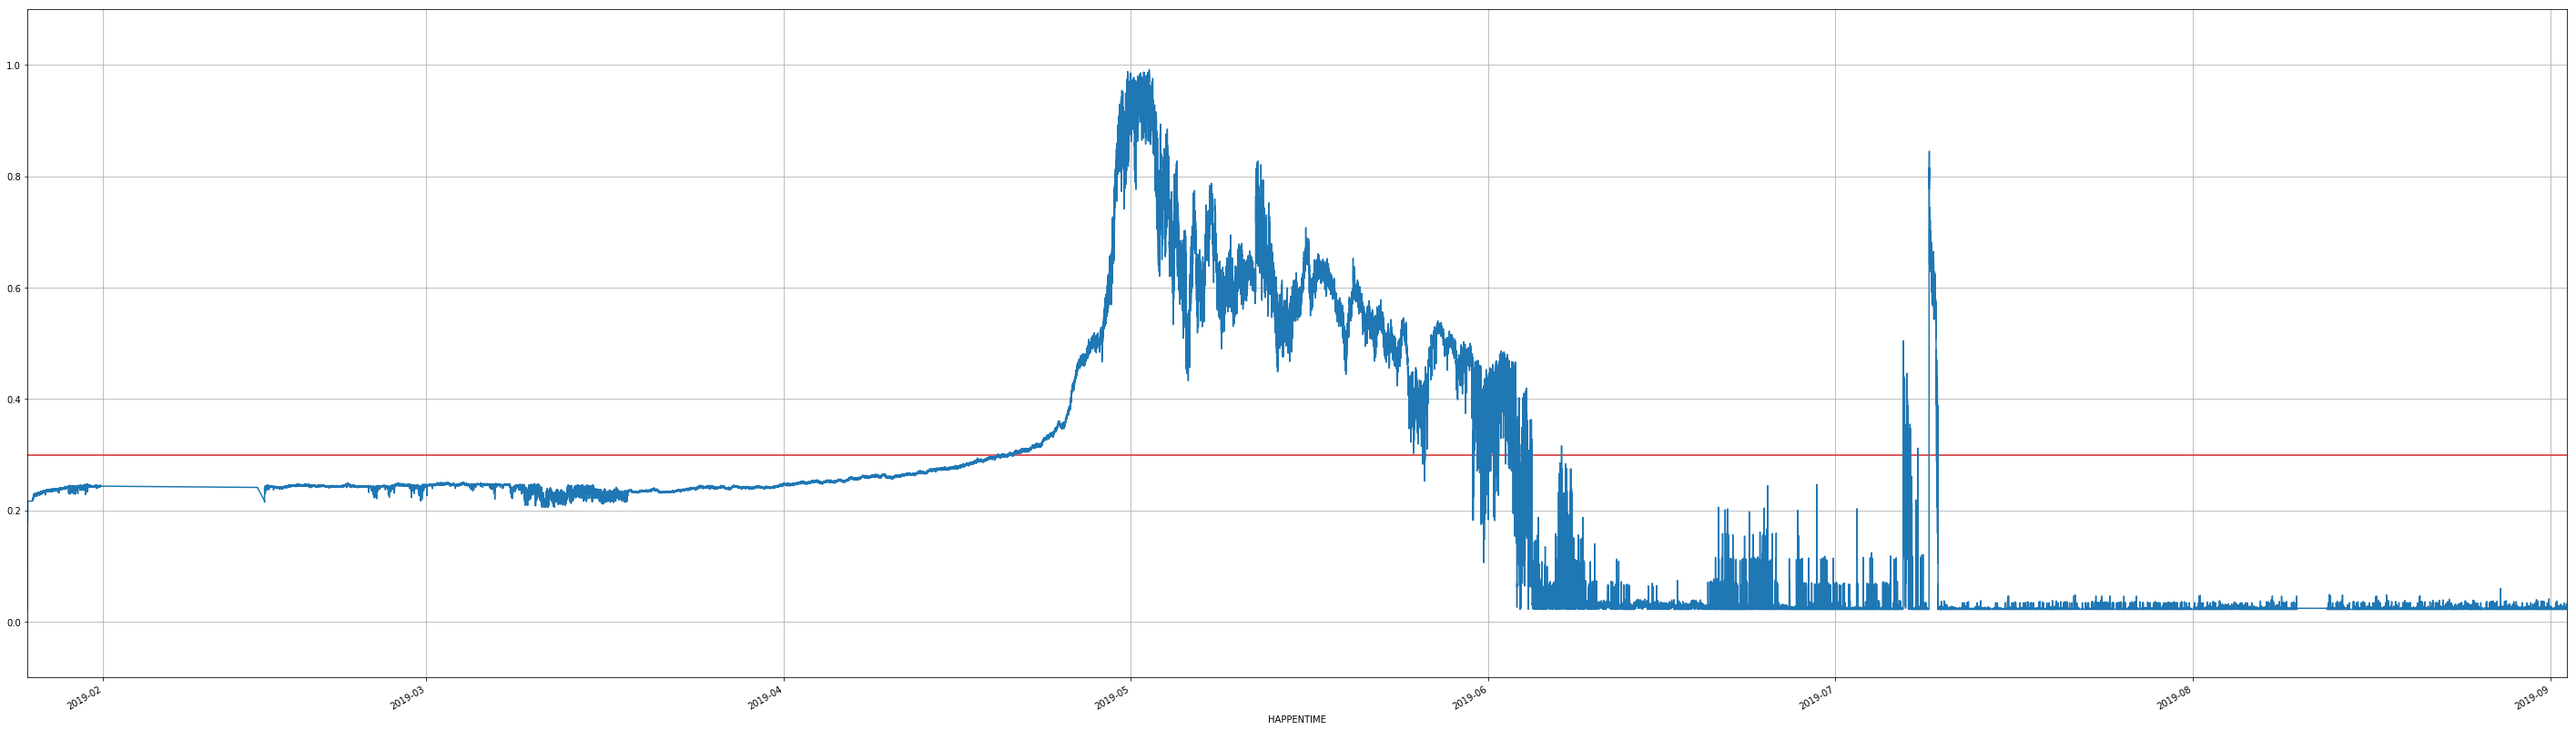

In [17]:
short_rolling_data_open=data_s_open['cv'].rolling(10,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(short_rolling_data_open.index[0],short_rolling_data_open.index[-1])
plt.axhline(y=0.3, color='#d62728')#画横线y=0.3
short_rolling_data_open.plot()
plt.grid()

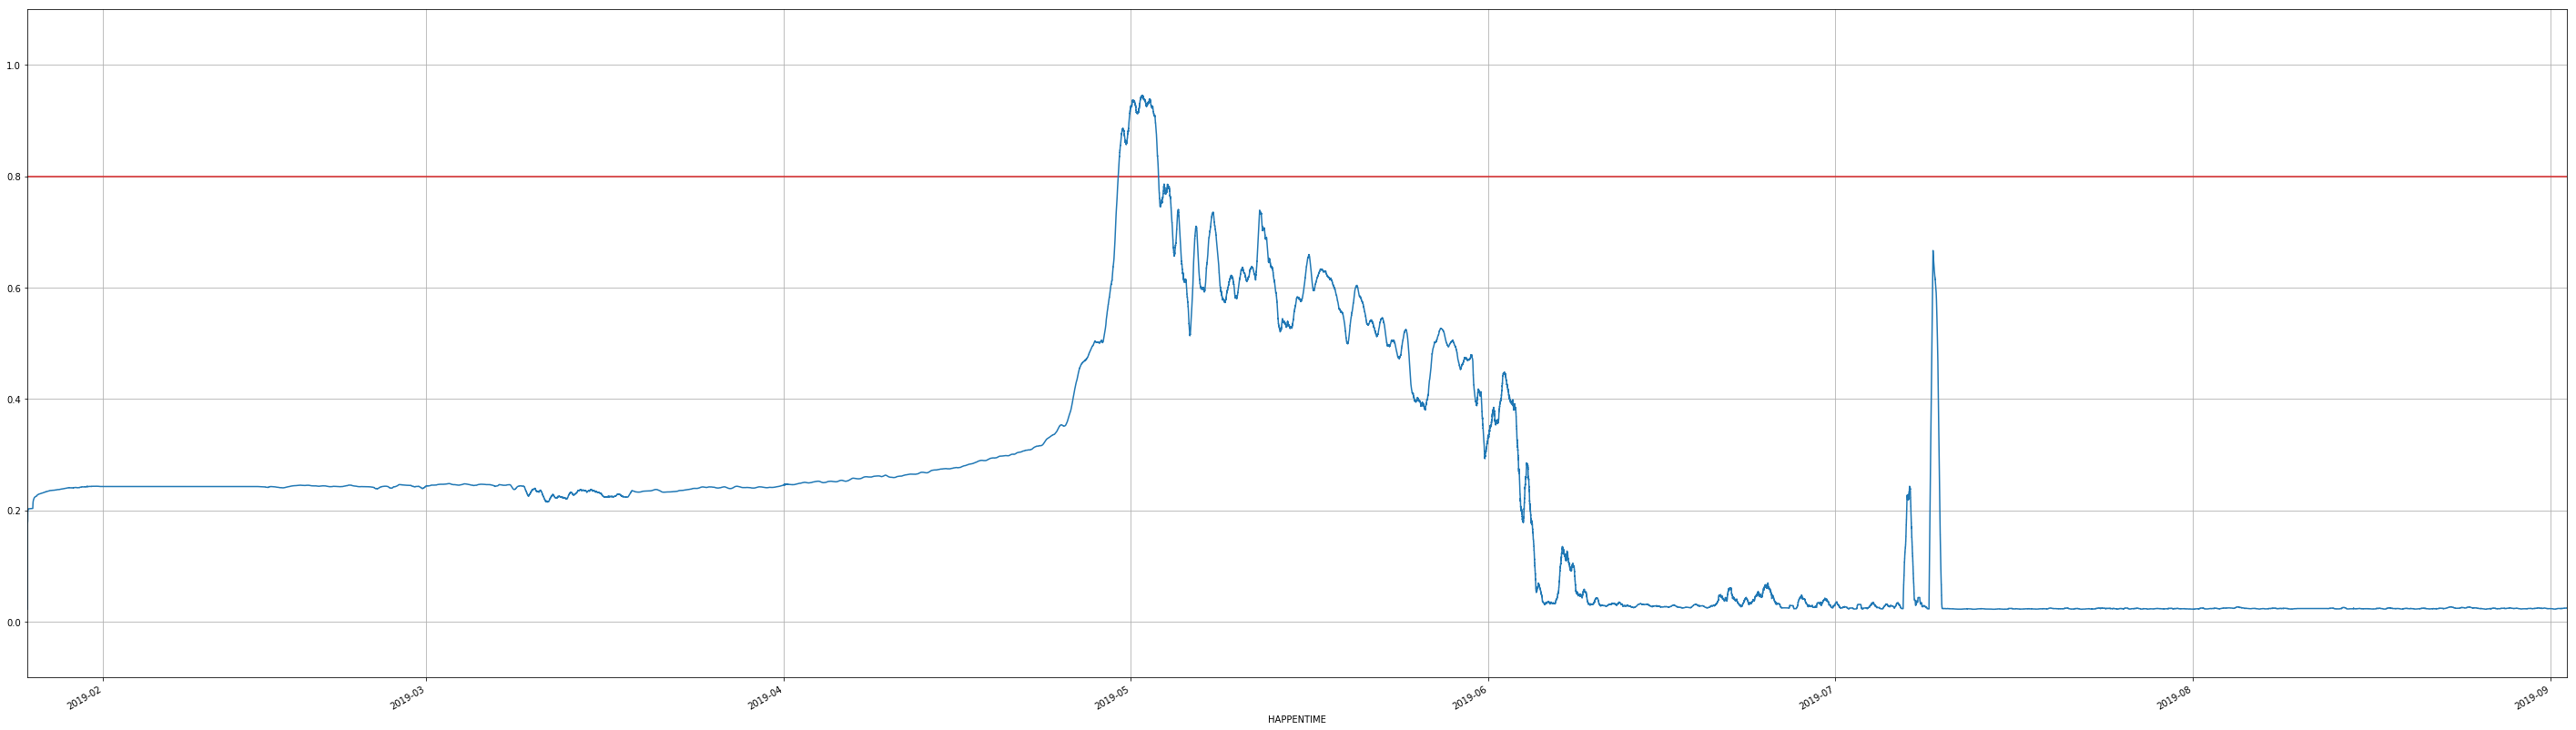

In [18]:
long_rolling_data_open=data_s_open['cv'].rolling(500,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(long_rolling_data_open.index[0],long_rolling_data_open.index[-1])
plt.axhline(y=0.8, color='#d62728')#画横线y=0.3

long_rolling_data_open.plot()
plt.grid()

### 关门数据

In [19]:
#建立高斯混合模型---关门状态
if __name__ == '__main__':
    k = 1
    cv1 = np.zeros(1)
    data_so = data_st2_sd.copy()
    data_s = data_st2_sd.copy()
    
    normal_obj = joblib.load(filesave+'\onlycan_closedata_normal_obj_model1.pkl') 
    a = len(data_s)
    cv = np.zeros(a)

    
    #使用高斯混合模型进行计算
    def gmm_apply(x,k,normal_obj):
        data_l = pd.DataFrame(x)
        test_obj = gmm_clustering(k,data_l)#test_obj为训练好的gmm模型，需保存
        y = calculate_cv(normal_obj,test_obj)#y为[[cv值]]，只返回cv值
        
        return y[0][0]
    
    #计算每一行的cv值，存在data_s的cv列中         
    data_s['cv']=data_s.apply(lambda row:gmm_apply(row,k,normal_obj), axis=1)
    
    #计算cv的均值
    #cv1= data_s['cv']#cv1为Series
    #print(type(cv1))
    c = data_s['cv'].mean()
    #计算cv值小于设定阈值的个数
    count =0    
    data_s['health_label']=data_s['cv'].map(count_gmm) 
    count=data_s['health_label'].sum()   
    
    
    print(a)
    print(count)    
    print(c)
   # print(cv1.head())
    data_s_close=data_s.copy()


292097
16608
0.32274382001490304


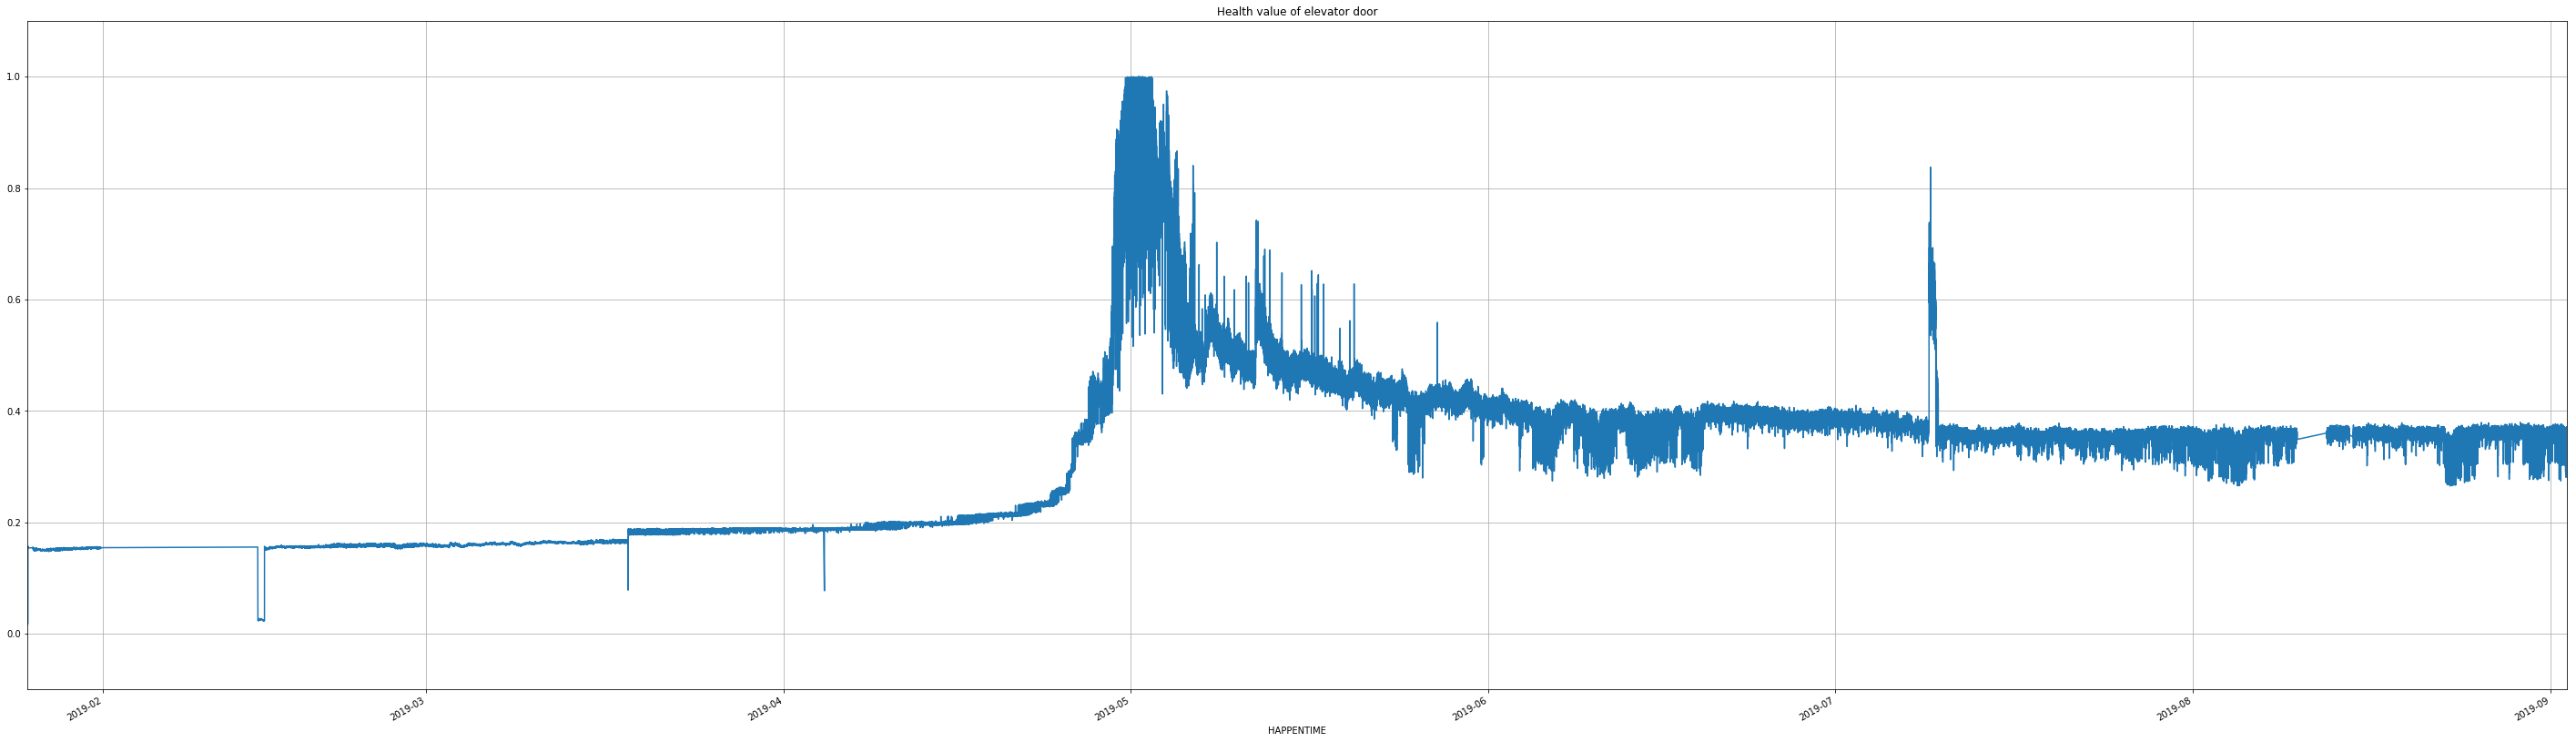

In [20]:
#画图    
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
#plt.xlim(0,14287)
plt.xlim(data_s_close.index[0],data_s_close.index[-1])
#plt.plot(data_s['cv'])
data_s_close['cv'].plot()

plt.grid()
plt.title('Health value of elevator door')
plt.show()


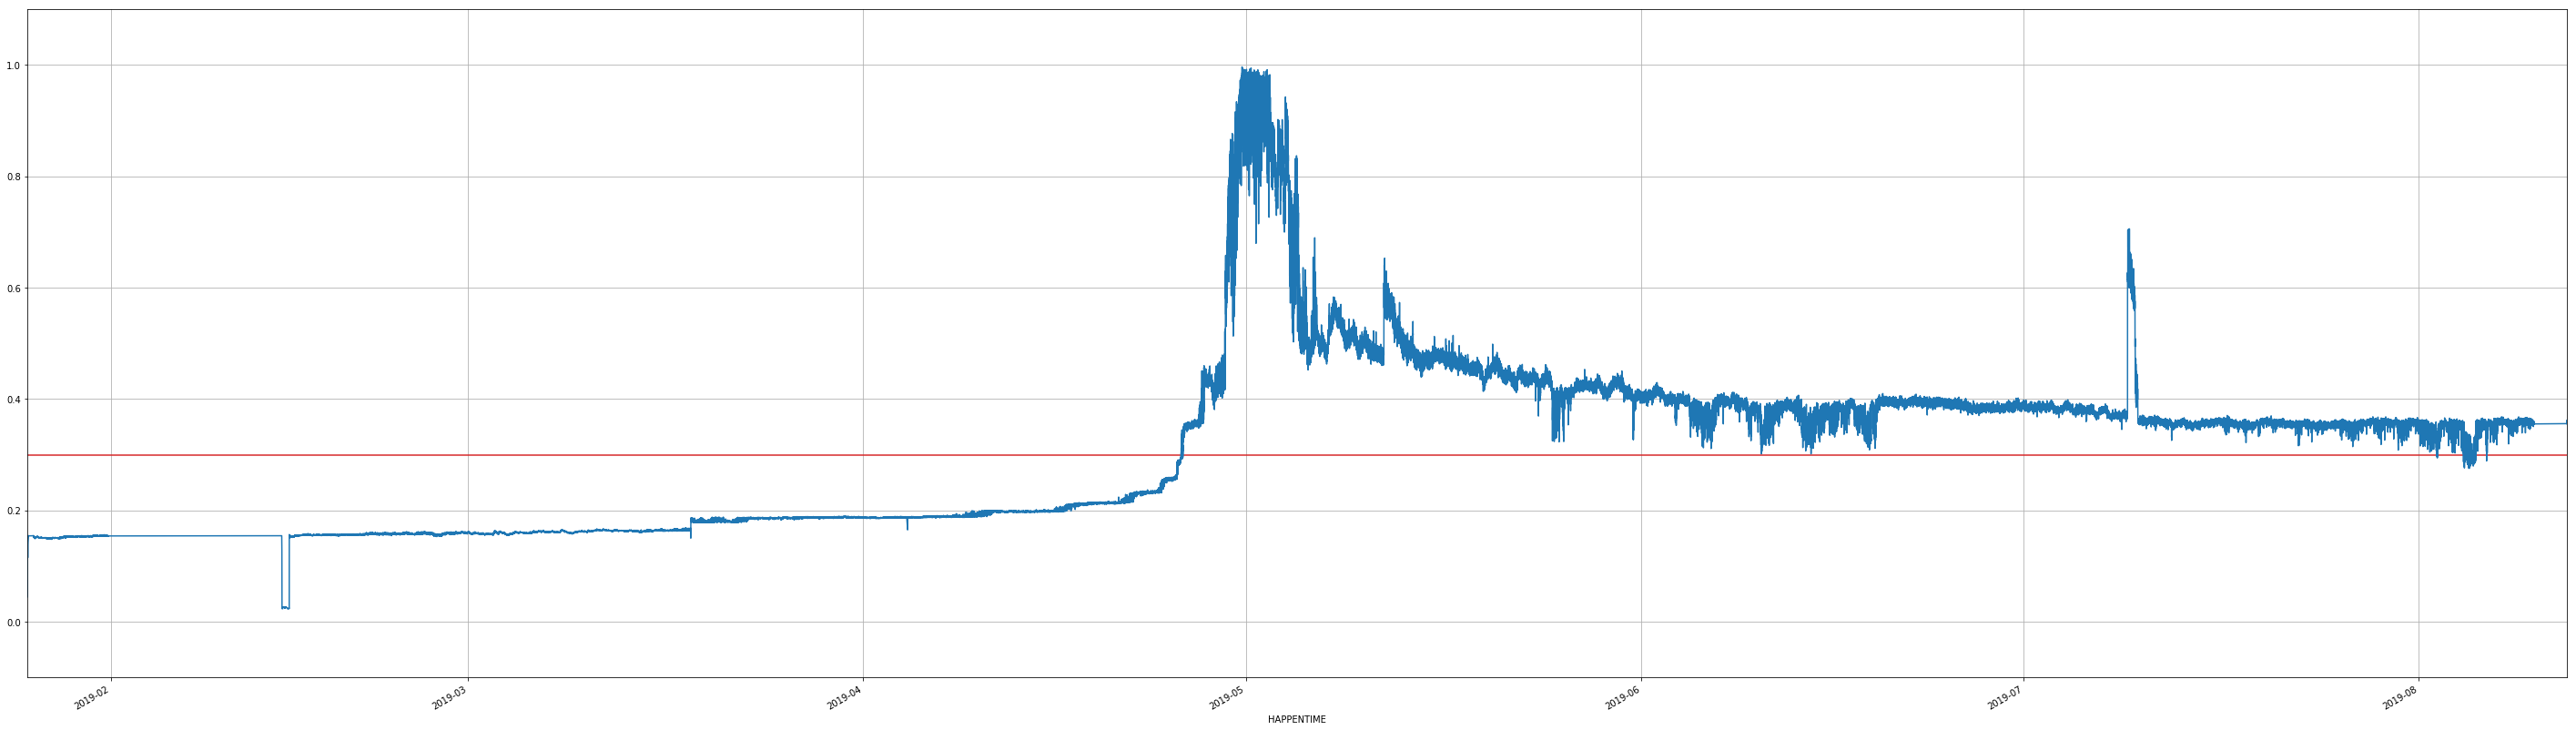

In [53]:
short_rolling_data_close=data_s_close['cv'].rolling(5,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(short_rolling_data_close.index[0],short_rolling_data_close.index[-1])
plt.axhline(y=0.3, color='#d62728')#画横线y=0.3
short_rolling_data_close.plot()
plt.grid()

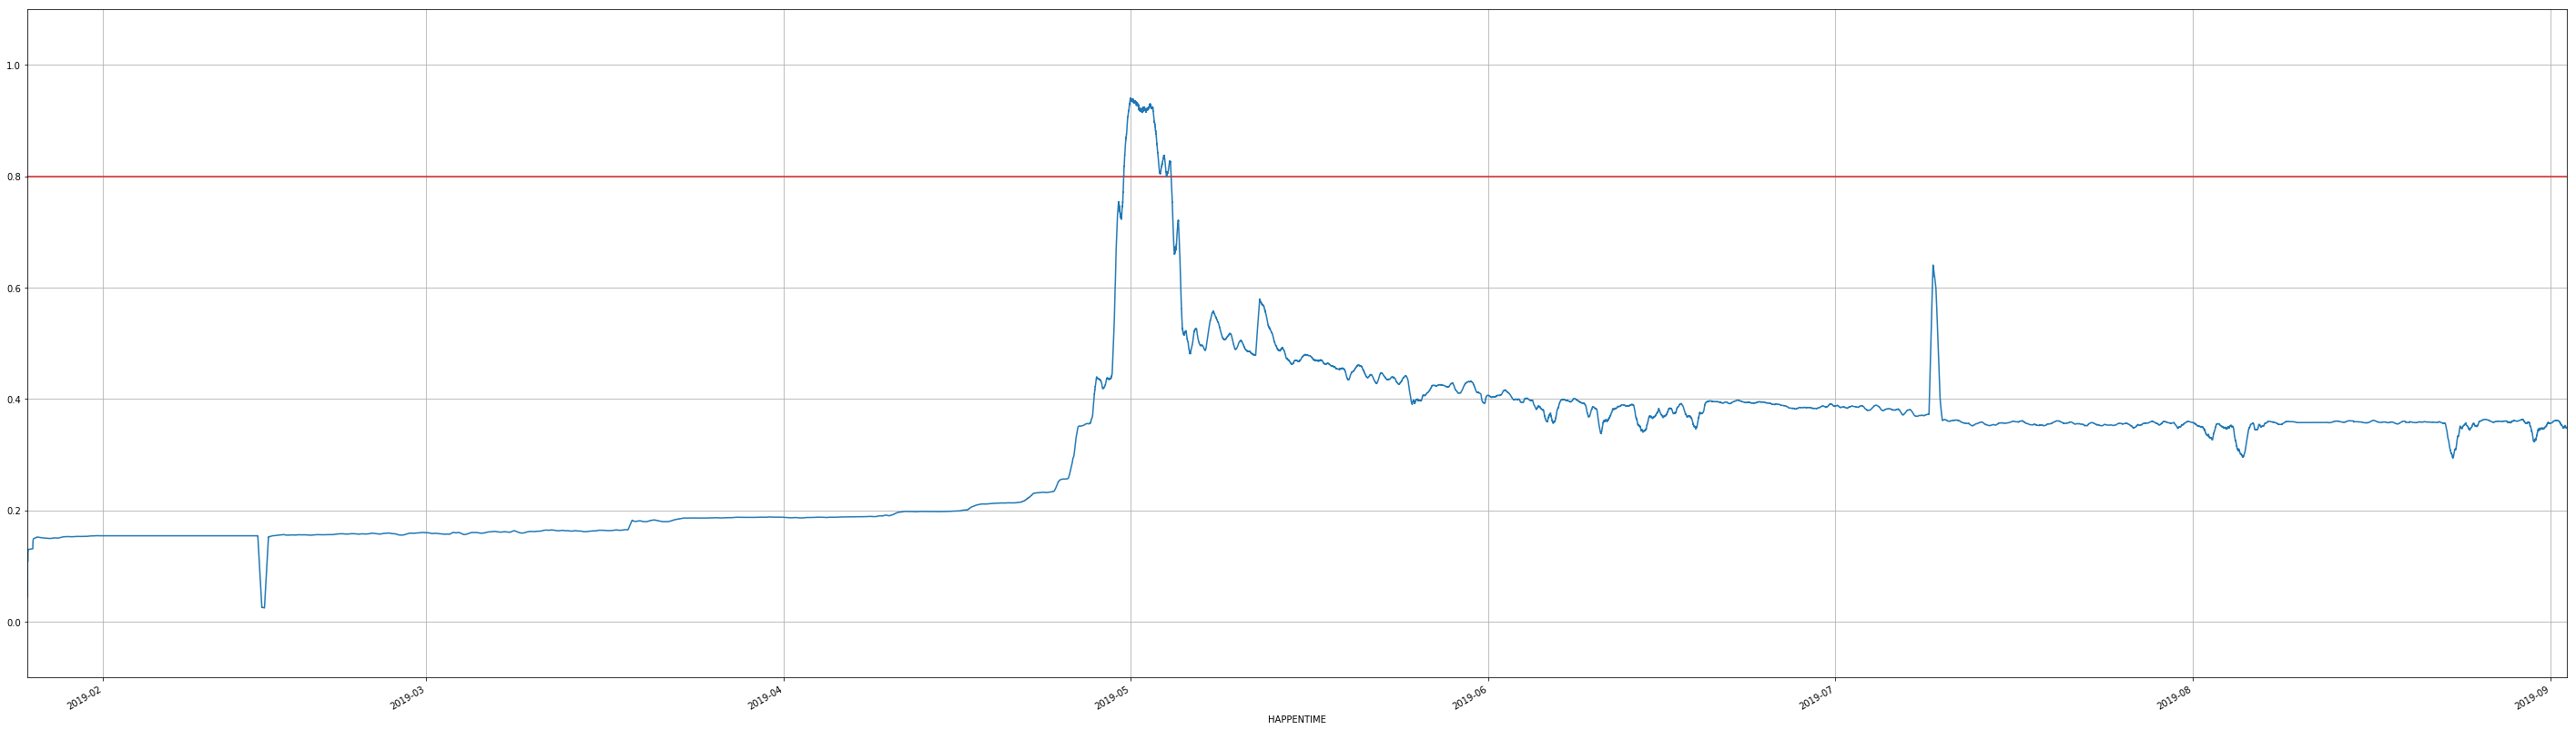

In [21]:
long_rolling_data_close=data_s_close['cv'].rolling(500,min_periods=1).mean()
plt.figure(figsize=(50,15))
plt.ylim((-0.1,1.1))#确认一下
plt.xlim(long_rolling_data_close.index[0],long_rolling_data_close.index[-1])
plt.axhline(y=0.8, color='#d62728')#画横线y=0.3
long_rolling_data_close.plot()
plt.grid()

In [22]:
data_s_close['cv'].to_csv('door1_close_cv_0502.csv', sep=',', header=True, index=True)